In [1]:
import numpy as np 
import pandas as pd 
import optuna 
from catboost import CatBoostClassifier,Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score,accuracy_score, confusion_matrix, classification_report,precision_score,f1_score,average_precision_score,roc_auc_score
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
PROJECT_ROOT = Path.cwd().parent
os.chdir(PROJECT_ROOT)

In [3]:
X = pd.read_csv("data/fe/X_train_fe.csv")
y = pd.read_csv("data/fe/y_train.csv").squeeze()

In [4]:
cat_features = [X.columns.get_loc(c) for c in ["Sex", "Embarked", "Title"]]

In [5]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [7]:
def objective(trial: optuna.Trial) ->float:
    params = {
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "random_seed": 42,
        "verbose": 0,
        #Гиперпараметры
        "iterations":trial.suggest_int("iterations", 300, 1500),
        "learning_rate":trial.suggest_float("learning_rate", 0.01, 0.2,log=True),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 50.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0, log=True),
        #регуляризация
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.6, 1.0),
    }
    aucs  = []
    for train_idx,val_idx in cv.split(X,y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        train_pool = Pool(X_tr, y_tr, cat_features=cat_features)
        val_pool = Pool(X_val, y_val, cat_features=cat_features)
        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=val_pool, use_best_model=True, early_stopping_rounds=50)
        y_score = model.predict_proba(val_pool)[:, 1]
        aucs.append(roc_auc_score(y_val, y_score))
    return float(np.mean(aucs))    
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print("Best CV AUC:", study.best_value)
print("Best params:", study.best_params)
    

[I 2025-12-26 07:07:47,394] A new study created in memory with name: no-name-d738a63c-f123-433b-9c12-33b7b43f9022
[I 2025-12-26 07:08:01,287] Trial 0 finished with value: 0.8864134817347983 and parameters: {'iterations': 442, 'learning_rate': 0.047313301798396955, 'depth': 4, 'l2_leaf_reg': 1.3339482502582394, 'random_strength': 1.1173221313497669e-07, 'subsample': 0.6041208913195937, 'colsample_bylevel': 0.8398206296645567}. Best is trial 0 with value: 0.8864134817347983.
[I 2025-12-26 07:08:36,126] Trial 1 finished with value: 0.8807625497398226 and parameters: {'iterations': 492, 'learning_rate': 0.10493952389108799, 'depth': 9, 'l2_leaf_reg': 1.7273883570668063, 'random_strength': 0.0007132828698054301, 'subsample': 0.7244865596409936, 'colsample_bylevel': 0.9890794841627982}. Best is trial 0 with value: 0.8864134817347983.
[I 2025-12-26 07:08:58,369] Trial 2 finished with value: 0.876915761586608 and parameters: {'iterations': 1225, 'learning_rate': 0.08980138312681261, 'depth': 9

Best CV recall: 0.8927976209324171
Best params: {'iterations': 990, 'learning_rate': 0.11259106221707173, 'depth': 6, 'l2_leaf_reg': 11.87587263040382, 'random_strength': 7.648910999303057e-09, 'subsample': 0.6192826572382713, 'colsample_bylevel': 0.9749762483569742}


In [8]:
X_test = pd.read_csv("data/fe/X_test_fe.csv")
y_test = pd.read_csv("data/fe/y_test.csv").squeeze()


In [9]:
best_params = study.best_params
final_params = {
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "random_seed": 42,
    "verbose": 100,
    **best_params
}

In [10]:
train_pool = Pool(X, y, cat_features=cat_features)
test_pool  = Pool(X_test, y_test, cat_features=cat_features)

In [11]:
final_model = CatBoostClassifier(**final_params)
final_model.fit(train_pool)

0:	total: 24.8ms	remaining: 24.5s
100:	total: 2.56s	remaining: 22.5s
200:	total: 5.03s	remaining: 19.7s
300:	total: 7.92s	remaining: 18.1s
400:	total: 10.7s	remaining: 15.8s
500:	total: 13.6s	remaining: 13.3s
600:	total: 16.5s	remaining: 10.7s
700:	total: 19.2s	remaining: 7.9s
800:	total: 21.5s	remaining: 5.08s
900:	total: 23.9s	remaining: 2.36s
989:	total: 26s	remaining: 0us


In [18]:
y_score = final_model.predict_proba(test_pool)[:, 1]
print("Test AUC:", roc_auc_score(y_test, y_score))

Test AUC: 0.8499341238471674


In [19]:
y_pred = (y_score >= 0.5).astype(int)
print("Test Recall:", recall_score(y_test, y_pred))
print("Test Precision:", precision_score(y_test, y_pred))
print("Test F1:", f1_score(y_test, y_pred))
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test PR-AUC:", average_precision_score(y_test, y_score))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Test Recall: 0.7101449275362319
Test Precision: 0.8032786885245902
Test F1: 0.7538461538461538
Test Accuracy: 0.8212290502793296
Test PR-AUC: 0.8174003144245519
Confusion matrix:
 [[98 12]
 [20 49]]


In [20]:
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Confusion matrix:
 [[98 12]
 [20 49]]
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       110
           1       0.80      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



In [21]:
accuracy = accuracy_score(y_test, y_pred)
error_rate = 1 -accuracy
print(f'Точность R^2: {accuracy}')
print(f'Доля ошибочных классификаций: {error_rate}')

Точность R^2: 0.8212290502793296
Доля ошибочных классификаций: 0.17877094972067042


Text(50.722222222222214, 0.5, 'True Label')

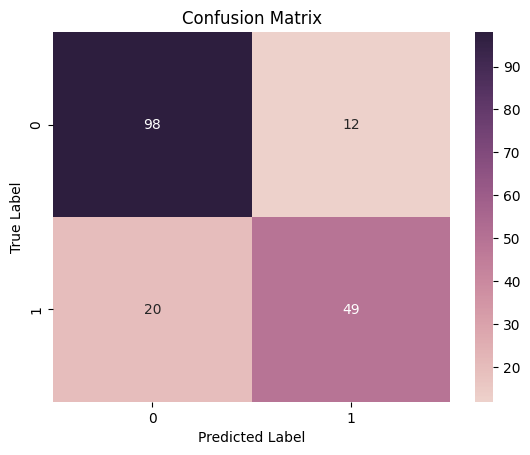

In [22]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')